# Sender Buffer Timespan Analysis

Date: 22.06.2020, by Maria Sharabayko

The motivation of the current analysis is to check the hypothesis that under normal conditions sender buffer remains within [RTT, RTT+10] ms diaposon and to make the formula more precise if needed.

Sender buffer timespan is one of the metrics used in the current implementation of [Makito Network Adaptive Encoding algorithm](https://haivision.jira.com/wiki/spaces/MK/pages/209112669/MakitoX+Network+Adaptive+Streaming). The algorithm creates a low and high thresholds calculated from the configured SRT Latency, and between which the sender buffer size should remain. According to my understanding, the low threshold is calculated as 33% of configured SRT latency and the high threshold is calculated as 200% of configured SRT latency. SRT latency is usually configured as 3-4 times RTT and I think Makito is not an exception.

If our hypothesis is true, it means that it makes more sense to use the RTT based (not latency) diaposon for low and high thresholds of the SRT sender buffer timespan.

In [1]:
import pandas as pd

import buffer_timespan as bt

## Buffer Timespan vs Available Buffer

In [2]:
# Define root path containing experiment results 
root_path = '/Users/msharabayko/projects/srt/lib-srt-utils/_send_buffer_datasets_17.06.20_2mins/'
algo_dir = root_path + 'periodic_nak/'
df = pd.read_csv(algo_dir + '_rtt20_loss0_sendrate5_latency80/2-srt-xtransmit-stats-snd.csv', sep=",", skipinitialspace=True)
df = df[['pktSent', 'byteAvailSndBuf', 'msSndBuf']]

# Sender buffer fullness in bytes according to byteAvailSndBuf statistic
df['sndBufFullness'] = df.loc[0, 'byteAvailSndBuf'] - df['byteAvailSndBuf']
# Delete the very first row where the buffer is empty
df = df.iloc[1:]
# Packets in sender buffer according to byteAvailSndBuf statistics, 1500 bytes per packet
df['pktsSndBuf'] = df['sndBufFullness'] / 1500
# Then calculate the difference in time between packets in ms
# Statistics has been collected each 100ms, so that we divide 100 by pktSent and get the difference in ms
df['calculated_msSndBuf'] = 100 / df['pktSent']
# Then multiply by the number of packets that are currently present in buffer pktsSndBuf
# Round down to the nearest integer
df['calculated_msSndBuf'] = df['calculated_msSndBuf'] * df['pktsSndBuf']
df['calculated_msSndBuf'] = df['calculated_msSndBuf'].astype('int32')
print(df.head(10))

    pktSent  byteAvailSndBuf  msSndBuf  sndBufFullness  pktsSndBuf  \
1        47       1019001000        26           19500        13.0   
2        48       1019001000        26           19500        13.0   
3        47       1019004000        22           16500        11.0   
4        48       1018999500        28           21000        14.0   
5        48       1019002500        24           18000        12.0   
6        47       1019004000        22           16500        11.0   
7        48       1019004000        22           16500        11.0   
8        48       1019001000        26           19500        13.0   
9        47       1019001000        26           19500        13.0   
10       48       1019002500        24           18000        12.0   

    calculated_msSndBuf  
1                    27  
2                    27  
3                    23  
4                    29  
5                    25  
6                    23  
7                    22  
8                    

As a result, `msSndBuf` and calculated out of the `byteAvailSndBuf` statistic sender buffer timespan `calculated_msSndBuf` should be almost equal +-1 packet.

## Data Collection

The data was collected using flip-flop-lanforge setup where Lanforge was used to emulate RTT and packet loss on a link.
It's important to note that `msSndBuf`, `msRcvBuf` statistics are instantenious, not moving average.

The directory with test results has the following structure:

```
root_path/
    |--- periodic_nak/
    |        |--- _rtt40_loss0_sendrate10_latency140/
    |        |        |--- 1-srt-xtransmit-stats-rcv.csv
    |        |        |--- 2-srt-xtransmit-stats-snd.csv
    |        |--- _rtt40_loss0_sendrate10_latency150/
    |        |        |--- 1-srt-xtransmit-stats-rcv.csv
    |        |        |--- 2-srt-xtransmit-stats-snd.csv
    |        |--- ...
```
    
The datasets can be found here(TODO: Insert the link).

The following values of RTT were used during the simulation: 20ms, 40ms, 100ms. The actual values of RTT, in milliseconds, measured by `ping 192.168.3.2 -c 20` command (the average through running the command three times) were

In [3]:
rtt_0 = 1.111
rtt_20 = 21.046
rtt_40 = 41.085
rtt_100 = 101.059

## Sender Buffer Timespan Analysis (Loss Ratio = 0%)

In [4]:
# Define root path containing experiment results 
root_path = '/Users/msharabayko/projects/srt/lib-srt-utils/_send_buffer_datasets_17.06.20_2mins/'

# Define the list of algos: tuples containing algo name and algo path inside root_path   
algos = [
    ('Periodic NAK', 'periodic_nak/')
]

# Load datasets for a specified set of algos (subfolders of root path)
df = bt.load_datasets(root_path, algos)

# Insert actual rtt column in df
df['actual_rtt'] = df['rtt']
df.loc[df['rtt']==20,'actual_rtt'] = rtt_20
df.loc[df['rtt']==40,'actual_rtt'] = rtt_40
df.loc[df['rtt']==100,'actual_rtt'] = rtt_100

print(df.head())
print(df.tail())

   rtt  loss  sendrate  latency          algo  loss_reports_ratio  \
0   20     0         5       10  Periodic NAK                 0.0   
1   20     0         5       15  Periodic NAK                 0.0   
2   20     0         5       20  Periodic NAK                 0.0   
3   20     0         5       25  Periodic NAK                 0.0   
4   20     0         5       30  Periodic NAK                 0.0   

   retransm_ratio  loss_ratio  drop_ratio  snd_buffer_max_fullness  \
0             0.0         0.0         0.0                  25500.0   
1             0.0         0.0         0.0                  30000.0   
2             0.0         0.0         0.0                  25500.0   
3             0.0         0.0         0.0                  27000.0   
4             0.0         0.0         0.0                  27000.0   

   rcv_buffer_max_fullness  snd_buffer_min_timespan  snd_buffer_max_timespan  \
0                   9000.0                     17.0                     34.0   
1   

Let's filter `df` dataframe so that loss=0%, algo='Periodic NAK'; then group by rtt, sendrate and plot the min, mean, max sender buffer timespan as well as the predicted diapason.

**The prediction diaposon is calculated as [RTT, RTT + 10] ms.**

Important note: Ideally, we should additionally substract the timespan of 1 packet from this diaposon, because the timespan is calculated as `time_last_packet - time_first_packet`. E.g., if we send 100pkts in 10ms (1.645Mbps, 1 packet=1316bytes), 1 packet timespan will be 0.1ms. This value depends on the sending rate. The higher the sending rate, the lower 1 packet timespan. It's relatively small in comparison with RTT, so that we neglect this value in further analysis.  

Important note: The actual value of RTT obtained via ping is used in the following analysis. RTT estimation (moving average) can be also obtained from the SRT statistics, however it's important to note that the higher the sending rate, the less the estimation. E.g., I've mentioned that in case of emulating RTT=100ms when ping RTT is about 101ms (101.59ms in our case), SRT statistics gives appr-ly 100.9ms at 5Mbps, 100.5 at 50Mbps. But this should verified additionally. It was just a quick look to the data. 

As can be seen from the plots,
- For a particular RTT, maximum sender buffer timespan are always higher than the prediction diaposon independently on the sending rate,
- For a particular RTT, minimum sender buffer timespan are below the prediction diaposon and it's getting closer as the sending rate increases,
- Average sender buffer timespan are within the prediction diaposon,
- For the same values of RTT, loss ratio, and sendrate, the variability in min, mean values of sender buffer timespan is close to zero while the variability in max sender buffer timespan is quite high. The 95% confidence interfals for sender buffer timespan for different parameters can be found below,
- For the same values of RTT, loss ratio, and sendrate, there is no dependency on the latency value.

Regarding maximum sender buffer timespan, I've checked the actual loss ratio which is equal to 0 in all the cases. So, it's not the reason.

/Users/msharabayko/projects/srt/lib-srt-utils/buffer_timespan.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['snd_buffer_min_timespan_predict'] = df['actual_rtt']
/Users/msharabayko/projects/srt/lib-srt-utils/buffer_timespan.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['snd_buffer_max_timespan_predict'] = df['actual_rtt'] + 10


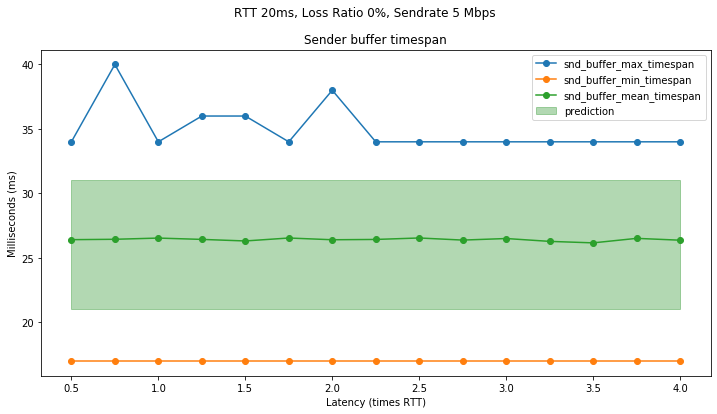

/Users/msharabayko/projects/srt/lib-srt-utils/buffer_timespan.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['snd_buffer_min_timespan_predict'] = df['actual_rtt']
/Users/msharabayko/projects/srt/lib-srt-utils/buffer_timespan.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['snd_buffer_max_timespan_predict'] = df['actual_rtt'] + 10


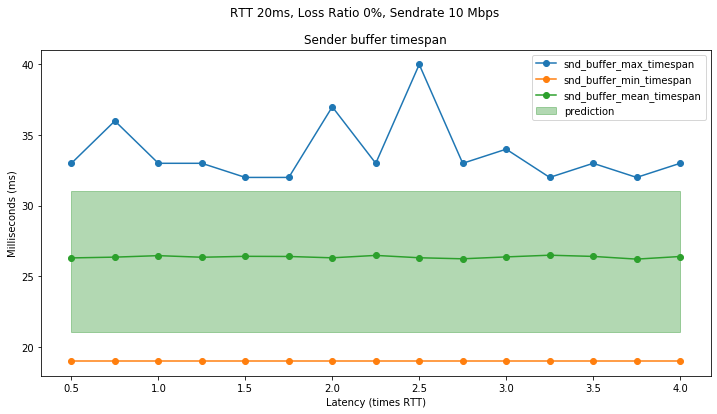

/Users/msharabayko/projects/srt/lib-srt-utils/buffer_timespan.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['snd_buffer_min_timespan_predict'] = df['actual_rtt']
/Users/msharabayko/projects/srt/lib-srt-utils/buffer_timespan.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['snd_buffer_max_timespan_predict'] = df['actual_rtt'] + 10


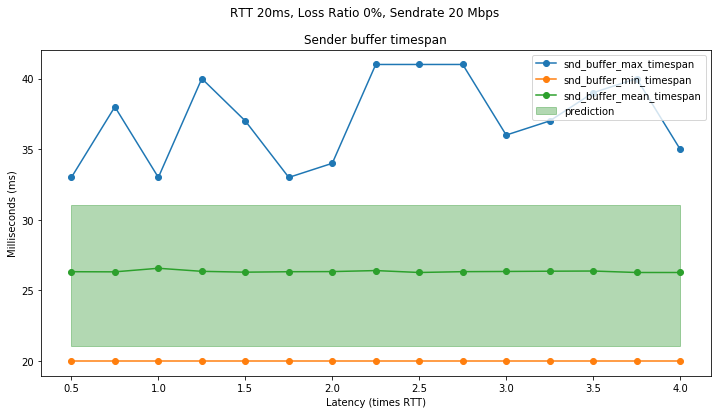

/Users/msharabayko/projects/srt/lib-srt-utils/buffer_timespan.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['snd_buffer_min_timespan_predict'] = df['actual_rtt']
/Users/msharabayko/projects/srt/lib-srt-utils/buffer_timespan.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['snd_buffer_max_timespan_predict'] = df['actual_rtt'] + 10


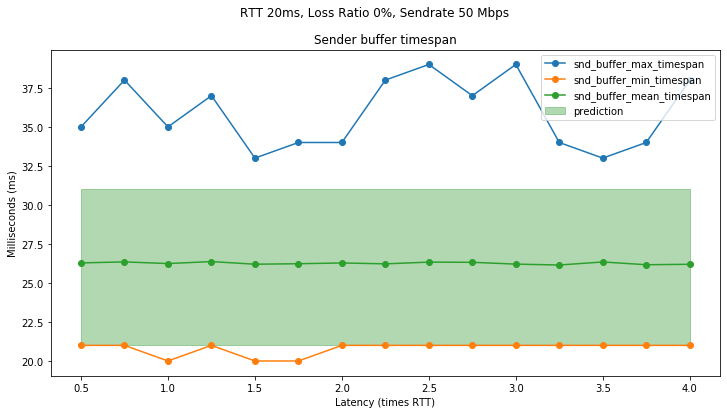

/Users/msharabayko/projects/srt/lib-srt-utils/buffer_timespan.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['snd_buffer_min_timespan_predict'] = df['actual_rtt']
/Users/msharabayko/projects/srt/lib-srt-utils/buffer_timespan.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['snd_buffer_max_timespan_predict'] = df['actual_rtt'] + 10


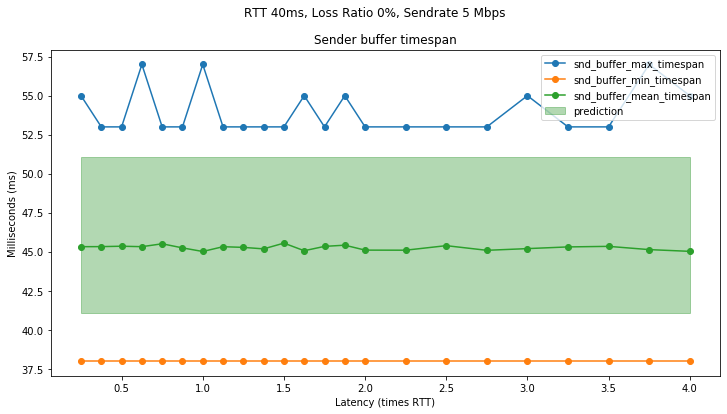

/Users/msharabayko/projects/srt/lib-srt-utils/buffer_timespan.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['snd_buffer_min_timespan_predict'] = df['actual_rtt']
/Users/msharabayko/projects/srt/lib-srt-utils/buffer_timespan.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['snd_buffer_max_timespan_predict'] = df['actual_rtt'] + 10


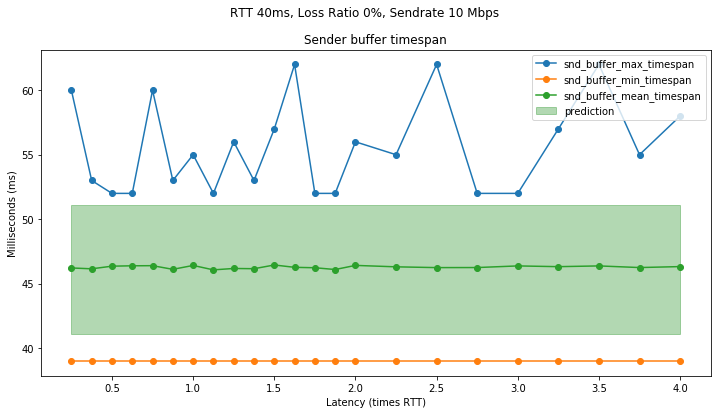

/Users/msharabayko/projects/srt/lib-srt-utils/buffer_timespan.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['snd_buffer_min_timespan_predict'] = df['actual_rtt']
/Users/msharabayko/projects/srt/lib-srt-utils/buffer_timespan.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['snd_buffer_max_timespan_predict'] = df['actual_rtt'] + 10


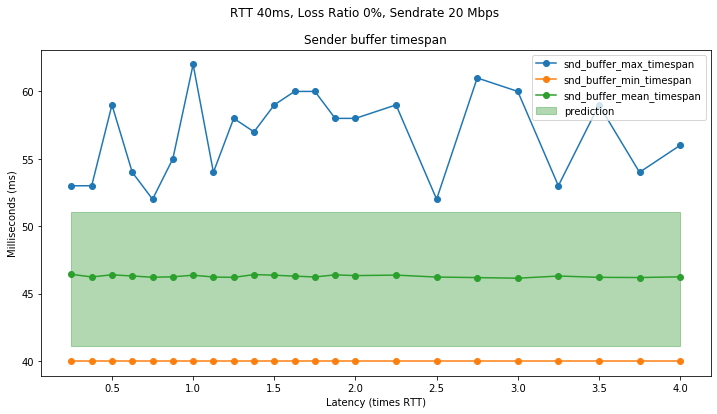

/Users/msharabayko/projects/srt/lib-srt-utils/buffer_timespan.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['snd_buffer_min_timespan_predict'] = df['actual_rtt']
/Users/msharabayko/projects/srt/lib-srt-utils/buffer_timespan.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['snd_buffer_max_timespan_predict'] = df['actual_rtt'] + 10


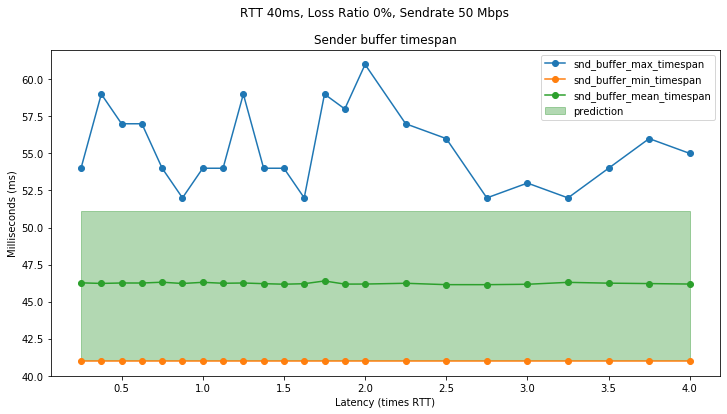

In [5]:
df_loss0 = df[(df['loss']==0) & (df['algo']=='Periodic NAK')]
splitting = df_loss0.groupby(['rtt', 'sendrate'])
for group_name, group in splitting:
    bt.plot_snd_buffer_timespan(group)

Let's find 95% confidence intervals for min, mean, and max sender buffer timespan for a particular RTT, sending rate, loss ratio (0% in our case) across multiple latency values (starting 0.5xRTT, ending 4xRTT in our case).

In [6]:
conf_df = df_loss0.groupby(['rtt', 'sendrate'])[['snd_buffer_min_timespan', 'snd_buffer_max_timespan', 'snd_buffer_mean_timespan']].agg(bt.confidence_interval_95)
print(conf_df)

             snd_buffer_min_timespan snd_buffer_max_timespan  \
rtt sendrate                                                   
20  5                   (17.0, 17.0)            (34.0, 39.3)   
    10                  (19.0, 19.0)           (32.0, 38.95)   
    20                  (20.0, 20.0)            (33.0, 41.0)   
    50                  (20.0, 21.0)            (33.0, 39.0)   
40  5                   (38.0, 38.0)            (53.0, 57.0)   
    10                  (39.0, 39.0)            (52.0, 62.0)   
    20                  (40.0, 40.0)           (52.0, 61.45)   
    50                  (41.0, 41.0)            (52.0, 59.9)   

             snd_buffer_mean_timespan  
rtt sendrate                           
20  5                   (26.2, 26.54)  
    10                 (26.22, 26.49)  
    20                 (26.27, 26.51)  
    50                 (26.16, 26.36)  
40  5                  (45.02, 45.53)  
    10                 (46.08, 46.43)  
    20                 (46.17, 46.42)  

Let us plot a histogram and define percentage of data out of [RTT, RTT+10] ms boundaries for a particular experiment (in our case RTT=20ms, loss=0%, sendrate=5Mbps, latency=80ms). It appears to be 7.86%.

7.86


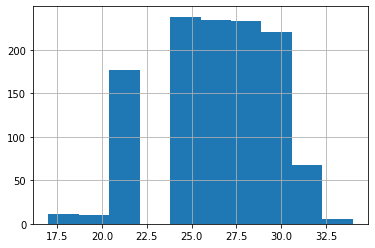

In [7]:
algo_dir = root_path + 'periodic_nak/'
single_df = pd.read_csv(algo_dir + '_rtt20_loss0_sendrate5_latency80/2-srt-xtransmit-stats-snd.csv', sep=",", skipinitialspace=True)
series = single_df['msSndBuf']
# Drop the first row where msSndBuf=0
series = series.iloc[1:]
series.hist()
percentage = round((1 - series.between(rtt_20, rtt_20 + 10).sum() / series.count()) * 100, 2)
print(percentage)

Let us plot the histograms and determine how much data is out of [RTT, RTT+10] ms boundaries across different aggregations.

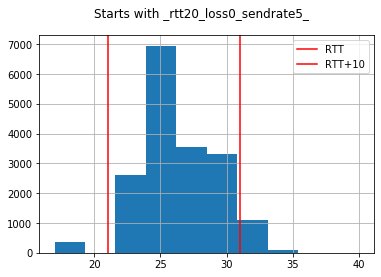

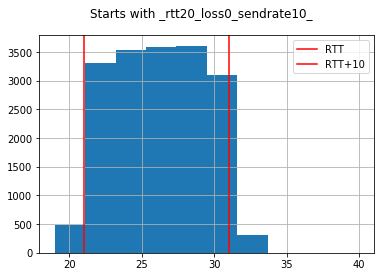

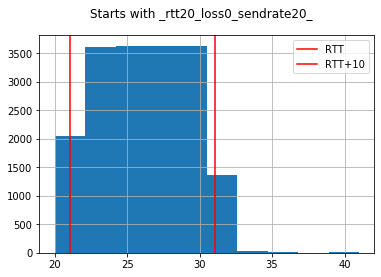

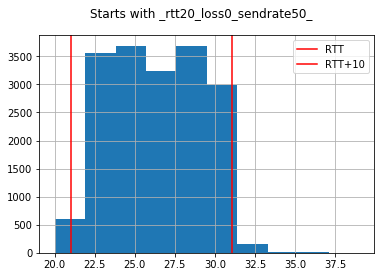

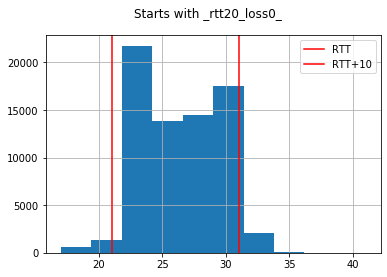

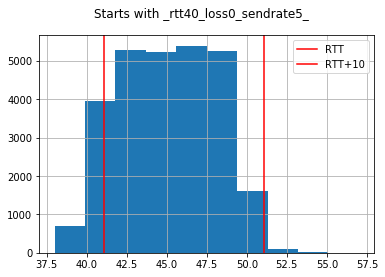

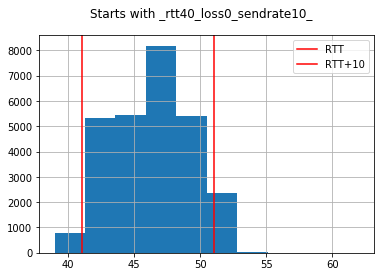

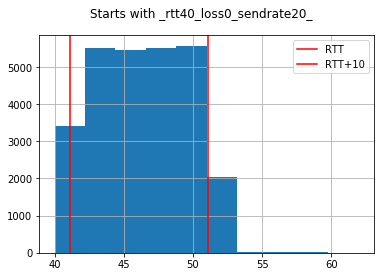

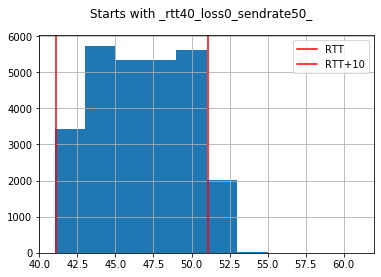

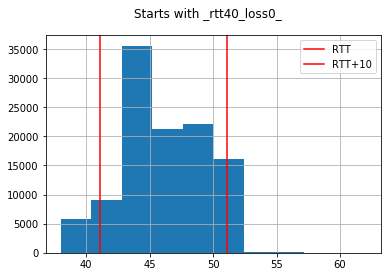

In [8]:
data = []
sndcsv = '2-srt-xtransmit-stats-snd.csv'

starts_with_20 = [
    '_rtt20_loss0_sendrate5_',
    '_rtt20_loss0_sendrate10_',
    '_rtt20_loss0_sendrate20_',
    '_rtt20_loss0_sendrate50_',
    '_rtt20_loss0_'
]

starts_with_40 = [
    '_rtt40_loss0_sendrate5_',
    '_rtt40_loss0_sendrate10_',
    '_rtt40_loss0_sendrate20_',
    '_rtt40_loss0_sendrate50_',
    '_rtt40_loss0_'
]

for s in starts_with_20:
    total, below, higher, conf_int_95, conf_int_99 = bt.define_percentage(algo_dir, s, sndcsv, rtt_20)
    data += [{'rtt': 20, 'starts_with': s, 'total': total, 'below RTT': below, 'higher RTT+10': higher, 'conf_int_95': conf_int_95, 'conf_int_99': conf_int_99}]
    
for s in starts_with_40:
    total, below, higher, conf_int_95, conf_int_99 = bt.define_percentage(algo_dir, s, sndcsv, rtt_40)
    data += [{'rtt': 40, 'starts_with': s, 'total': total, 'below RTT': below, 'higher RTT+10': higher, 'conf_int_95': conf_int_95, 'conf_int_99': conf_int_99}]

The following dataframe shows the idea of how much data is out of [RTT, RTT+10] ms boundaries across different aggregations, in %. See columns `total`, `below RTT`, `higher RTT+10`.

In [9]:
perc_df = pd.DataFrame(data, columns=['rtt', 'starts_with', 'total', 'below RTT', 'higher RTT+10', 'conf_int_95', 'conf_int_99'])
print(perc_df)

   rtt               starts_with  total  below RTT  higher RTT+10  \
0   20   _rtt20_loss0_sendrate5_   8.58       2.00           6.59   
1   20  _rtt20_loss0_sendrate10_   4.50       2.71           1.79   
2   20  _rtt20_loss0_sendrate20_   6.11       2.83           3.28   
3   20  _rtt20_loss0_sendrate50_   4.41       3.40           1.00   
4   20             _rtt20_loss0_   5.90       2.73           3.17   
5   40   _rtt40_loss0_sendrate5_  17.29      16.90           0.40   
6   40  _rtt40_loss0_sendrate10_   4.22       2.91           1.31   
7   40  _rtt40_loss0_sendrate20_   6.23       3.24           2.99   
8   40  _rtt40_loss0_sendrate50_   5.63       4.49           1.15   
9   40             _rtt40_loss0_   8.34       6.88           1.46   

    conf_int_95   conf_int_99  
0  (22.0, 32.0)  (17.0, 32.0)  
1  (20.0, 31.0)  (19.0, 32.0)  
2  (21.0, 32.0)  (20.0, 32.0)  
3  (21.0, 31.0)  (21.0, 32.0)  
4  (21.0, 32.0)  (19.0, 32.0)  
5  (38.0, 51.0)  (38.0, 51.0)  
6  (40.0, 51.0) 

 As a result,
- 9.05% in total, 1.08% below RTT and 8.21% higher RTT+10 as the maximum of _rtt20_loss0 and _rtt40_loss_0,
- 10.62% in total, 1.75% below RTT and 9.25% higher RTT+10 as the maximum across all the starts_with values from dataframe `perc_df`.

In [10]:
print(perc_df.loc[perc_df['starts_with']=='_rtt20_loss0_', ['starts_with', 'total', 'below RTT', 'higher RTT+10']])
print(perc_df.loc[perc_df['starts_with']=='_rtt40_loss0_', ['starts_with', 'total', 'below RTT', 'higher RTT+10']])

print('\nMaximum')
print(perc_df[['total', 'below RTT', 'higher RTT+10']].max())

     starts_with  total  below RTT  higher RTT+10
4  _rtt20_loss0_    5.9       2.73           3.17
     starts_with  total  below RTT  higher RTT+10
9  _rtt40_loss0_   8.34       6.88           1.46

Maximum
total            17.29
below RTT        16.90
higher RTT+10     6.59
dtype: float64


Columns `conf_int_95` and `conf_int_99` correspond to 95% and 99% confidence intervals for `msSndBuf` for a particular series.

In [11]:
conf_rtt20 = perc_df.loc[perc_df['starts_with']=='_rtt20_loss0', 'conf_int_99']
conf_rtt40 = perc_df.loc[perc_df['starts_with']=='_rtt40_loss0', 'conf_int_99']

print(conf_rtt20)
print(conf_rtt40)
print(type(conf_rtt20))


# perc_df['boundaries'] = (perc_df['rtt'], perc_df['rtt']+10)

# perc_df['rtt+10'] = perc_df['rtt'] + 10
# perc_df['low'] = 100 - perc_df['min'] * 100 / perc_df['rtt']
# perc_df['high'] = perc_df['max'] * 100 / perc_df['rtt+10'] - 100
# print(perc_df)

Series([], Name: conf_int_99, dtype: object)
Series([], Name: conf_int_99, dtype: object)
<class 'pandas.core.series.Series'>


Conclusion: I think that as a start it makes sense to use the maximum obtained percentage to make the formula more precise. So that we can define the low and high thresholds of sender buffer timespan for Makito NAE algorithm as follows:
- low threshold = 

## Sender Buffer Timespan Analysis (Loss Ratio = 4%)

/Users/msharabayko/projects/srt/lib-srt-utils/buffer_timespan.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['snd_buffer_min_timespan_predict'] = df['actual_rtt']
/Users/msharabayko/projects/srt/lib-srt-utils/buffer_timespan.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['snd_buffer_max_timespan_predict'] = df['actual_rtt'] + 10


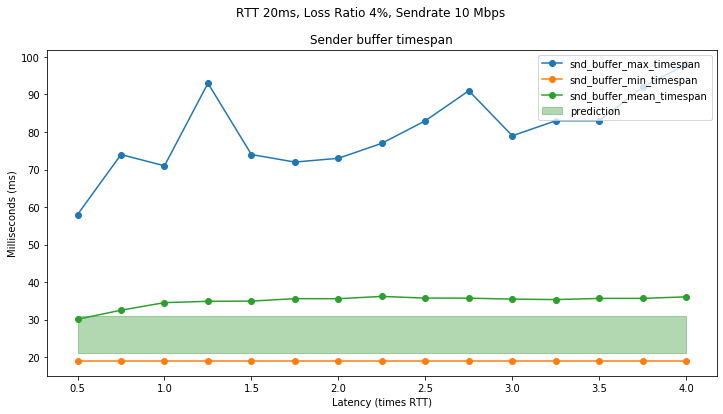

In [12]:
df_loss4 = df[(df['loss']==4) & (df['algo']=='Periodic NAK')]
splitting_loss4 = df_loss4.groupby(['rtt', 'sendrate'])
for group_name, group in splitting_loss4:
    bt.plot_snd_buffer_timespan(group)

/Users/msharabayko/projects/srt/lib-srt-utils/buffer_timespan.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['snd_buffer_min_timespan_predict'] = df['actual_rtt']
/Users/msharabayko/projects/srt/lib-srt-utils/buffer_timespan.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['snd_buffer_max_timespan_predict'] = df['actual_rtt'] + 10


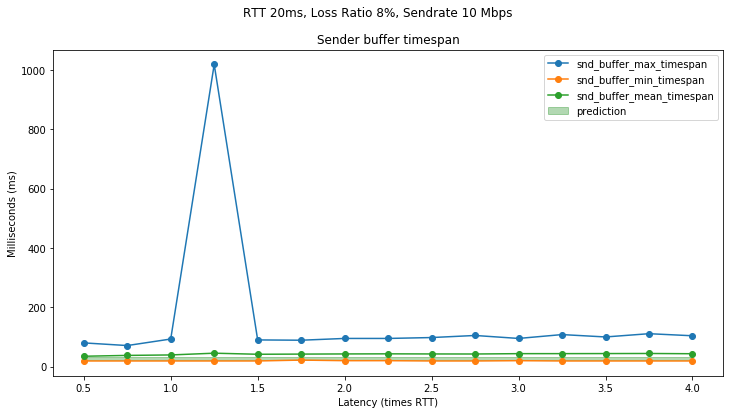

In [13]:
df_loss8 = df[(df['loss']==8) & (df['algo']=='Periodic NAK')]
splitting_loss8 = df_loss8.groupby(['rtt', 'sendrate'])
for group_name, group in splitting_loss8:
    bt.plot_snd_buffer_timespan(group)

TODO: scatter_matrix to check correlation
https://squidarth.com/rc/programming/networking/machine-learning/2018/08/15/rl-for-congestion-control.html
Congestion Control ML
Metrics to take into account: RTT, buffer timespan, loss, jitter (packet IAT), ACKs IAT